In [4]:
from pyspark.sql.functions import mean, udf, col, round, isnan, when, count
from pyspark.sql.types import DoubleType
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime 
print(datetime.datetime.now())
%matplotlib inline

# sc = SparkContext('local')
# spark = SparkSession(sc)

2019-07-11 14:30:40.899668


## import csv files into spark dataframes
Note: both files contain records from all 5 boroughs

In [5]:
df1 = spark.read.csv('../data/pluto.csv', header=True)
df2 = spark.read.csv('../data/pluto_18v2_1.csv', header=True)
# df3 = spark.read.csv('../data/pluto_18v1.csv', header=True)

In [6]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])
# df3 = df3.select([col(A).alias(A.lower()) for A in df3.schema.names])

In [7]:
double_columns = ['bldgarea', 'facilfar',
                  'residfar', 'commfar', 'numbldgs', 'numfloors', 'bldgdepth', 
                  'bldgfront', 'lotdepth', 'lotfront', 
                  'exempttot', 'exemptland',  'assessland', 'assesstot', 'builtfar']

In [8]:
cols = df2.columns

In [9]:
df1 = df1.select(cols)
df2 = df2.select(cols)
# df3 = df3.select(cols)

## Type Conversion

In [10]:
for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))
#     df3 = df3.withColumn(A, round(col(A).cast(DoubleType()), 2))

## Count Null and 0

In [11]:
null_1 = df1.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df1.columns]).toPandas()
condo_null_1 = df1.filter(df1['lot'].rlike(r'^75'))\
                    .select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df1.columns]).toPandas()

In [12]:
null_1

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
0,0,2,2,33769,33769,33769,33785,33769,33780,33825,...,828862,797851,7,0,0,0,0,863547,863554,7


In [13]:
condo_null_1

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
0,0,0,0,314,314,314,314,314,314,314,...,11830,11376,0,0,0,0,0,12485,12485,0


In [14]:
null_2 = df2.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df2.columns]).toPandas()
condo_null_2 = df2.filter(df2['lot'].rlike(r'^75'))\
                    .select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df2.columns]).toPandas()

In [57]:
# null_3 = df3.select([(count(when(isnan(c) | col(c).isNull(), 1))\
#                       + count(when(col(c)==0,1))).alias(c) for c in df3.columns]).toPandas()

In [18]:
# null_all = pd.concat([null_3, null_2, null_1])
null_all = pd.concat([null_2, null_1])
condo_null_all = pd.concat([condo_null_2, condo_null_1])

null_change = null_all.pct_change()
condo_null_change = condo_null_all.pct_change()

In [19]:
null_change.iloc[1,:].sort_values(ascending=False)[0:10]

ycoord       737.080342
xcoord       737.074359
address       54.287879
taxmap        53.584254
sanitsub      47.421271
sanborn       38.569431
tract2010     32.776000
ct2010        32.769000
council       32.769000
cd            32.769000
Name: 0, dtype: float64

In [20]:
condo_null_change.iloc[1,:].sort_values(ascending=False)[0:10]

xcoord       623.250000
ycoord       623.250000
sanborn       25.750000
taxmap        23.133333
sanitsub      22.466667
cd            18.625000
ct2010        18.625000
cb2010        18.625000
tract2010     18.625000
council       18.625000
Name: 0, dtype: float64

In [17]:
# null_change.iloc[2,:].sort_values(ascending=False)[0:10]

In [21]:
null_all.index = ['18v2_1', '19v1']
null_all

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
18v2_1,0,8,8,1000,1000,1000,1638,1000,20541,1673,...,824299,793294,6,6,6,6,6,858982,858982,6
19v1,0,2,2,33769,33769,33769,33785,33769,33780,33825,...,828862,797851,7,0,0,0,0,863547,863554,7


In [22]:
condo_null_all.index = ['18v2_1', '19v1']
condo_null_all

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
18v2_1,0,0,0,16,16,16,27,16,174,27,...,11697,11247,0,0,0,0,0,12346,12346,0
19v1,0,0,0,314,314,314,314,314,314,314,...,11830,11376,0,0,0,0,0,12485,12485,0


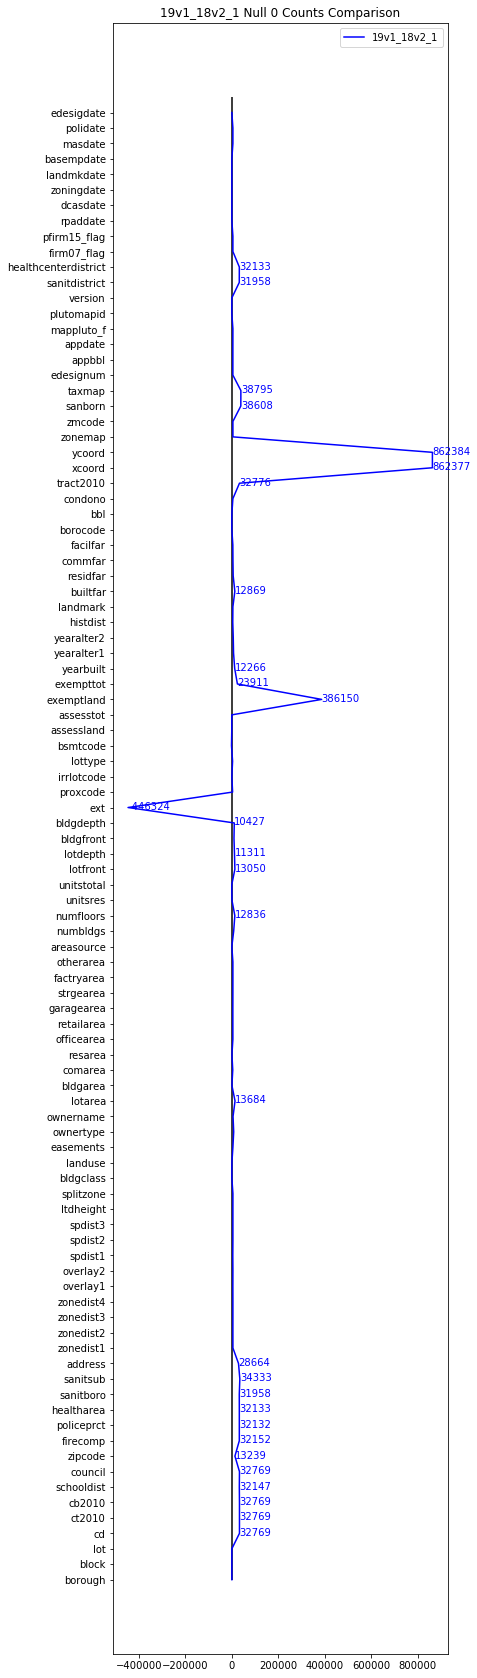

In [23]:
plt.figure(figsize=(6, 30))

difference1 = null_all.iloc[1, :]-null_all.iloc[0, :]
# difference2 = null_all.iloc[2, :]-null_all.iloc[1, :]

plt.plot(difference1, range(96), label = '19v1_18v2_1', color = 'blue')
# plt.plot(difference2, range(96), label = '18v2_18v1', color = 'red')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(difference1[i]) >= 10000:
        plt.text(x = difference1[i] , y = i - 0.15, s = '{}'.format(difference1[i]), size = 10, color = 'blue')
    else: 
        pass
    
# for i in range(96):
#     if abs(difference1[i]) >= 10000:
#         plt.text(x = difference1[i] , y = i-0.15, s = '{}'.format(difference1[i]), size = 10, color = 'red')
#     else: 
#         pass
    
plt.yticks(range(96), null_all.columns, rotation='horizontal')
# plt.title('19v1_18v2_18v1 Null 0 Counts Comparison')
plt.title('19v1_18v2_1 Null 0 Counts Comparison')
plt.legend()
# plt.savefig('19v1_18v2_18v1_Null0_Comparison.png', bbox_inches='tight')
plt.show()

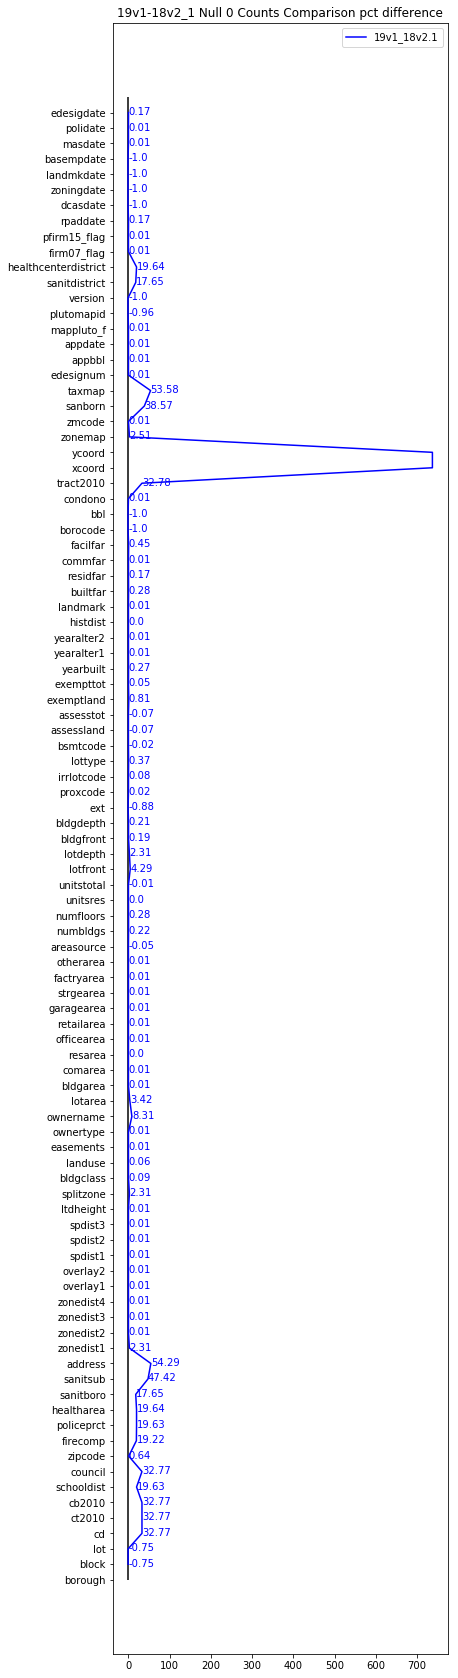

In [24]:
plt.figure(figsize=(6, 30))

plt.plot(null_change.iloc[1,:], range(96), label = '19v1_18v2.1', color = 'blue')
# plt.plot(null_change.iloc[1,:], range(96), label = '18v1_18v2', color = 'red')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(null_change.iloc[1,i]) <= 100:
        plt.text(x = null_change.iloc[1,i] , y = i - 0.15, s = '{}'.format(np.round(null_change.iloc[1,i], 2)), size = 10, color = 'blue')
    else: 
        pass
    
plt.yticks(range(96), null_all.columns, rotation='horizontal')
plt.title('19v1-18v2_1 Null 0 Counts Comparison pct difference')
plt.legend()
plt.savefig('19v1-18v2_1-Null0-Comparison-pct.png', bbox_inches='tight')
plt.show()

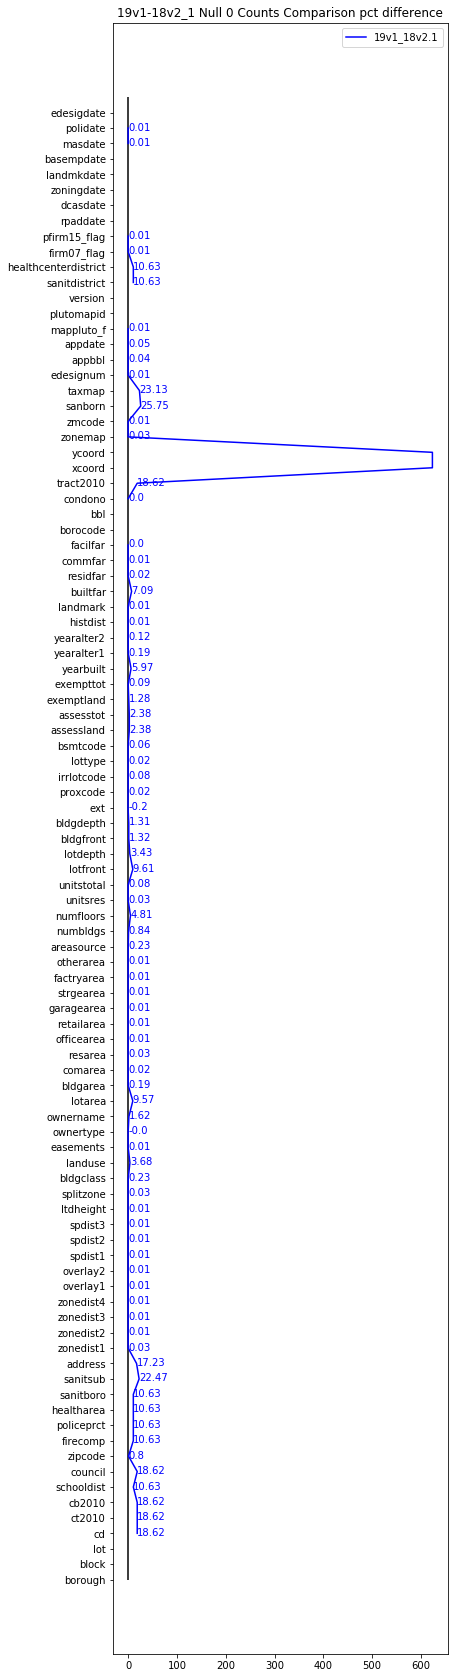

In [25]:
plt.figure(figsize=(6, 30))

plt.plot(condo_null_change.iloc[1,:], range(96), label = '19v1_18v2.1', color = 'blue')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(condo_null_change.iloc[1,i]) <= 100:
        plt.text(x = condo_null_change.iloc[1,i] , y = i - 0.15, s = '{}'.format(np.round(condo_null_change.iloc[1,i], 2)), size = 10, color = 'blue')
    else: 
        pass
    
plt.yticks(range(96), condo_null_change.columns, rotation='horizontal')
plt.title('19v1-18v2_1 Null 0 Counts Comparison pct difference')
plt.legend()
plt.savefig('19v1-18v2_1-Null0-Comparison-pct.png', bbox_inches='tight')
plt.show()